# 220831 find diameters

Find species diameters and all min-inter dists.

In [1]:
from pathlib import Path

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

## Setup

I like to put all the input/output file paths at the top so it's clear at a glance what they are:

In [3]:
DATESTR = '220831'
NBNAME = f'{DATESTR}_3-find-diameters'

In [4]:
infiles = dict(
    genomes='data-src/genomes.csv',
    species='data-src/taxa.csv',
    pw_dists='data-intermediate/220831-signatures-and-dists/pw-dists.csv',
)

In [5]:
data_intermediate = Path('data-intermediate') / NBNAME
data_intermediate.mkdir(exist_ok=True, parents=True)

outfiles = dict(
    species_data=data_intermediate / 'species-data.csv',
    min_inter=data_intermediate / 'min-inter.csv',
)

## Load data

In [6]:
genomes = pd.read_csv(infiles['genomes'])
ngenomes = genomes.shape[0]

species = pd.read_csv(infiles['species']).set_index('ncbi_taxid')
nspecies = species.shape[0]

In [7]:
dmat = pd.read_csv(infiles['pw_dists'], index_col=0)

In [8]:
# Reindex so that row/column order matches genomes table
accs = genomes['genbank_acc']
dmat = dmat.loc[accs, accs]

<AxesSubplot:>

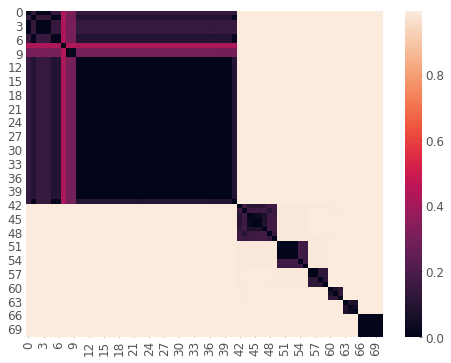

In [9]:
sns.heatmap(dmat.values)

## Distance statistics

In [10]:
# Integer indices of genomes by species
# (raw arrays correspond to order of species rows in table)
gb = genomes.groupby('ncbi_taxid')
species_inds = [gb.indices[taxid] for taxid in species.index]

diameters = np.zeros(nspecies)
min_inter = np.zeros((nspecies, nspecies))

# 1st species
for i, inds1 in enumerate(species_inds):
    diameters[i] = dmat.values[np.ix_(inds1, inds1)].max()
    
    # 2nd species, avoiding double counting
    for j, inds2 in enumerate(species_inds[:i]):
        mi = dmat.values[np.ix_(inds1, inds2)].min()
        min_inter[i, j] = min_inter[j, i] = mi

## Check for overlaps

This is a list of `(A, B)` tuples representing $A \to B$ edges in a directed graph.
$A \to B$ means the A-B min inter distance is $\leq$ the diameter of A.

If there were a very large number of species with many overlaps, you could decompose this graph into its connected components and fix each one independently.
But in this case all species are fairly distantly related so we expect it to be empty.

In [11]:
# Species represented here by row index in species table
overlaps = []

# For all pairs
for i in range(nspecies):
    for j in range(i):
        d = min_inter[i, j]
        if d <= diameters[i]:
            overlaps.append((i, j))
        if d <= diameters[j]:
            overlaps.append((j, i))
            
overlaps

[]

## Export data

In [12]:
# Add diameter and genome count to species table
species['diameter'] = diameters
species['ngenomes'] = genomes.groupby('ncbi_taxid').size()

species.to_csv(outfiles['species_data'])

In [13]:
# Min inter

mi_df = pd.DataFrame(min_inter, index=species.index, columns=species.index)
mi_df.to_csv(outfiles['min_inter'])